# Birb Cam Training Notebook

This is the notebook that trains a fast.ai vision model for the [Birb Cam](https://github.com/evjrob/birbcam) project. Ideally training should use a GPU to allow it to complete much faster than it would on a CPU. You can get access to a python environment with GPU through [Google Colab](https://colab.research.google.com/). This is how I train Birb Cam models. It relies heavily on the Fast.ai python package, and I strongly encourage you to read the [fastai documentation](https://docs.fast.ai/) if you would like to learn more. You may also enjoy the official [Fastai book](https://www.amazon.com/Deep-Learning-Coders-fastai-PyTorch/dp/1492045527), a wonderful resource that showed me how easy it could be to build practical ML solutions in next to no time.

### Packages

First we need to install and import the fastai package.

In [ ]:
# Uncomment the line below if running on Colab
!pip install fastai==2.2.7

In [ ]:
from fastai.vision.all import *

### Data

Next, we need the foundation of all machine learning projects: data.

You may already have this data stored locally on the computer you're training on. In this case you should comment out the google colab import and drive.mount lines and change the path to where your data is stored. I assume that this folder contains a subfolder called "training" which contains image files with the following naming scheme:

*label1_label2_..._date.jpg*

Where each label is a string identifying one species present in the image. Usually there is only one species. Date is a datetime string of the format *yyyy-mm-ddTHH:MM:SS*.

If you have an image from March 26, 2021 at 9:00 AM with just a squirrel in it the filename should be:

*squirrel_2021-03-26T09:00:00.jpg*

If five minutes later you observe a squirrel and a sparrow at the same time, the file name would be:

*squirrel__sparrow_2021-03-26T09:05:00.jpg*

This naming scheme is agnostic to what the labels are. You will likely have different species of interest, and as long as you choose a consistent string identifier for each one, the model will learn to recognize it just fine (provided there are no underscores or commas in the string). You can train the model to recognize eagles, parrots, or house cats.

In [ ]:
# Comment out the drive import if using local data, and change the path to point
# to the correct location. I assume the training data is in a sub-folder named
# "training" in this path.
from google.colab import drive
drive.mount('/content/gdrive')
path = Path(F"/content/gdrive/My Drive/birbcam/data/")
files = get_image_files(path/"training")

If the above import of training data has worked, you should see a non zero number of files after executing the cell below.

In [ ]:
len(files)

We need to tell fastai how to parse the labels by passing it the following regular expression.

In [ ]:
pattern = r'^(.*)_(\d|(\d{4})-(\d{2})-(\d{2})T(\d{2})\:(\d{2})\:(\d{2}))+.(jpg|JPG|jpeg|png)'

We also define a labeler function which will handle the splitting of the label string into each species and then rejoin them with commas to separate the values. Finally we apply this to all the file names to get a pair of columns mapping the files to the labels for the fastai learner.

In [ ]:
# A label splitter function
def labeler(x):
  x = str(x)
  x = x.split('/')[-1]
  x = x.split('_')
  x = x[:-1]
  if 'none' in x:
    x.remove('none')
  return ','.join(x)

# Create a data frame mapping file names to labels
df = pd.DataFrame({'fname': [str(f).split('/')[-1] for f in files]})
df['labels'] = df['fname'].apply(labeler)
#df = df[df['labels'] != '']
df = df.reset_index(drop=true)

In [ ]:
df.head()

,fname,labels
0,squirrel_2021-02-27T08:03:32.jpg,squirrel
1,squirrel_2021-02-27T08:03:33.jpg,squirrel
2,squirrel_2021-02-27T08:03:34.jpg,squirrel
3,squirrel_2021-02-27T08:03:43.jpg,squirrel
4,squirrel_2021-02-27T08:03:47.jpg,squirrel


### DataLoader

Now that we have a folder full of training data and a data frame of labels for the files in that folder. The next step is to load up the data into a fastai ImageDataLoaders using the from_df() function. What the fastai DataLoader does for us is manage the spliting of the data into a training and validation set, batching of the data, and applies a standard suite of transformations for data augmentation like rotations, skews, and mirroring.

That's a lot of the functionality required for high performing computer vision algorithms that we didn't need to write. Pretty cool!

Once we have the DataLoader, we can show a batch and see what the input images look like. 


In [ ]:
dls = ImageDataLoaders.from_df(df, path, folder='training', label_delim=',', 
                               item_tfms=Resize((320,240)), batch_tfms=aug_transforms(size=(320,240)))

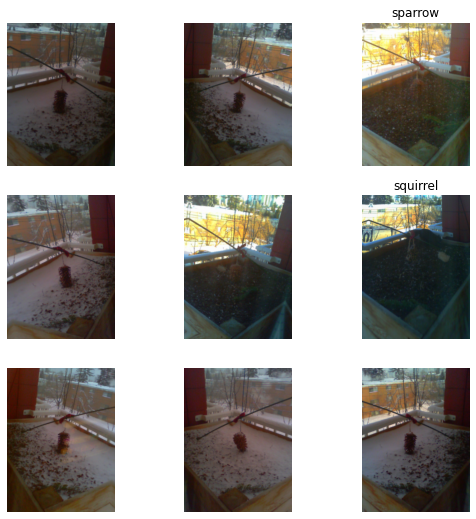

In [ ]:
dls.show_batch()

### Vision Model

Now that we have all our data loaded, we need a model. In fastai we can load a Convolutional Neual Network (CNN) based on the resnet34 architecure with one line. This line pre-loads trained resnet34 weights for the ImageNet trained on ImageNet, and sets the problem up to be multi-label where labels are not mutually exclusive.

In [ ]:
learn = cnn_learner(dls, resnet34, metrics=partial(accuracy_multi, thresh=0.5))

If you already have a pre-trained Birb Cam model, you can uncomment the line below and use the weights in that model as a starting point.

In [ ]:
# old_learn = load_learner(path/"models/birbcam_prod.pkl")
# old_learn.save('init_weights')
# learn.load('init_weights')

### Training

Now we're ready to train the model. The first step is to find a good learning rate. Too low and training can take a long time, or the model may even struggle to escape local minima. Too larger and the model can over shoot the minima and start to diverge badly. Luckily for us fastai provides the learning rate finder which will steer us right towards an optimal learning rate value.

SuggestedLRs(lr_min=0.04365158379077912, lr_steep=0.03981071710586548)

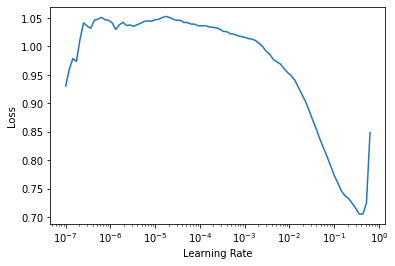

In [ ]:
learn.lr_find()

The next trick is to include something called mixup during training. Mixup is a means of blending labels and images to create a [blend of two different classes and their labels](https://docs.fast.ai/callback.mixup.html). With mixup defined, we can start training the model using the fine_tune() function. This is yet another super easy to use function in fastai that expertly handles the training in the context of a transfer learning problem like ours. We can train for ten epochs using the learning rate we found earlier.

In [ ]:
mixup = MixUp(1.)
learn.fine_tune(10, 2e-2, cbs=mixup)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.198327,0.135549,0.947136,03:12


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.139436,0.116606,0.972874,03:18
1,0.138325,0.110896,0.955021,03:18
2,0.130520,0.103663,0.968017,03:18
3,0.123431,0.121532,0.975524,03:19
4,0.117321,0.189815,0.960699,03:19
5,0.112835,0.101816,0.966061,03:19
6,0.104755,0.118864,0.967575,03:18
7,0.098346,0.104988,0.975524,03:18
8,0.094625,0.094866,0.981643,03:18
9,0.094199,0.101903,0.981390,03:18


We can save a checkpoint of the model now that will allow us to revert back to these weights if we find the model performance degrades.

In [ ]:
learn.save('first_cycles')

Path('/content/gdrive/My Drive/birbcam/data/models/first_cycles.pth')

In [ ]:
learn.load('first_cycles')

By default the fastai model does not train the full model; it leaves most of the early layers for detecting specific textures and features unmodified. It only trains what is referred to as the "classification head", a set of layers at the end of the model which are responsible for inspecting the earlier layer outputs and deciding what classes are in the image. We can allow training through the whole model by calling the unfreeze() method and then training more with a smaller learning rate.

In [ ]:
learn.unfreeze()
learn.fine_tune(5, 5e-3, cbs=mixup)

In [ ]:
learn.load('first_cycles')

### Model Interpretation

We can use the fastai Interpretation class to inspect the images the model is performing the worst on. This can be useful to see if there are any data integreity issues such as inaccurate labels.

In [ ]:
interp = Interpretation.from_learner(learn)

,target,predicted,probabilities,loss
0,magpie,,"tensor([0.0877, 0.0005, 0.3491, 0.0038])",2.0356085300445557
1,magpie,,"tensor([0.1124, 0.0029, 0.2575, 0.0412])",1.57583487033844
2,chickadee,sparrow,"tensor([0.0242, 0.0021, 0.6270, 0.1055])",1.2054928541183472
3,chickadee,,"tensor([1.0463e-02, 3.1309e-05, 6.3307e-02, 4.7940e-03])",1.1575287580490112
4,chickadee,,"tensor([1.0660e-02, 3.5547e-05, 6.8396e-02, 5.3892e-03])",1.1543891429901123
5,squirrel,,"tensor([0.3916, 0.0043, 0.4245, 0.0332])",1.114907145500183
6,squirrel,chickadee,"tensor([0.6853, 0.0044, 0.1134, 0.0450])",1.0952990055084229
7,magpie,,"tensor([0.1379, 0.0284, 0.2695, 0.1325])",1.0414307117462158
8,squirrel,,"tensor([0.0121, 0.0003, 0.0581, 0.0186])",1.013893485069275
9,squirrel,,"tensor([0.1159, 0.0004, 0.1984, 0.0252])",1.0059648752212524


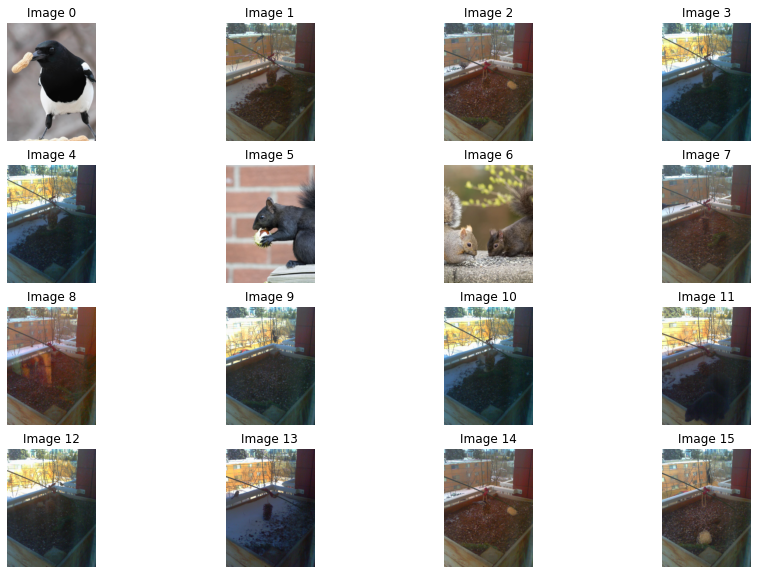

In [ ]:
interp.plot_top_losses(16, figsize=(15,10))

### Exporting the Model

Now we can export the model for production. This will save a pickle file that can can be copied to the Raspberry Pi to classify images of critters as they arrive.

In [ ]:
learn.export(path/"models/birbcam_prod.pkl")